In [598]:
"""
Name: Lauren Nguyen
Course: CPSC 222
Assignment: Final Project
Date: 12/3/2022
Description: Final Data Science project using wordle data to compute EDA, 
            statistics testing, and machine learning
"""
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\dzuy\\Desktop\\CPSC222\\project\\utils.py'>

## Data Description
My data that I will be using in this project comes from the internet game wordle. I have been tracking my daily attempts along with these attributes:
* Amount of tries(Tries)
* Date(Date)
* The word(Word)
* The time completed(Time)
* If I got the word(Got it)
## Loading the Data
First we load the data from a csv file into a pandas dataframe

In [599]:
uncleaned_df = utils.read_file("wordle_uncleaned.csv")
print(uncleaned_df.head())

      Date  Tries   Word      Time Got it
0  9/14/22    5.0  Thyme   8:58 AM    Yes
1  9/15/22    4.0  Doubt   9:09 AM    Yes
2  9/16/22    6.0  Parer   1:11 PM    Yes
3  9/17/22    NaN    NaN       NaN    NaN
4  9/18/22    5.0  Stick  11:33 AM    Yes


## Cleaning the data
Next, we need to clean the data up a little. There are some days of wordle that I had missed so I need to delete the rows where there is no data present. Then write to a new csv file called **"cleaned_wordle.csv"**

In [600]:
cleaned_df = utils.delete_missing_data(uncleaned_df)
cleaned_df.to_csv("cleaned_wordle.csv")

## **Agreggating Data**
For this, we will be computing statistics on our dataset, These calculations will include:
* Total days of Wordle completed
* Total Wordles completed in the morning
* Total Wordles completed in the night
* Most common amount of tries
* Average amount of tries
* Standard deviation of tries
* Average tries in the morning
* Standard deviation of tries in the morning
* Average tries in the night
* Standard deviation of tries in the night

Formulas to be used:  
Average: $\frac{1}{n} \sum_{i=i}^{n} x_{i}$  
Standard Deviation: $\sqrt{\frac{1}{N-1} \sum_{i=1}^N (x_i - \overline{x})^2}$  
Mode: l + h($\frac{f_{m}-f_{l}}{2f_{m}-f_{l}-f_{2}}$)


In [601]:
stats_list = utils.computed_statistics(cleaned_df)
statistics_headers = ["Total days of Wordle completed", "Total Wordles completed in the morning", "Total Wordles completed in the night", "Most common amount of tries"
                    , "Average amount of tries", "Standard deviation of tries", "Average tries in the morning", "Standard deviation of tries in the morning", 
                    "Average tries in the night", "Standard deviation of tries in the night"]
stats_series = pd.Series(stats_list, index= statistics_headers)
print(stats_series)

Total days of Wordle completed                70.000000
Total Wordles completed in the morning        50.000000
Total Wordles completed in the night          21.000000
Most common amount of tries                    5.000000
Average amount of tries                        4.800000
Standard deviation of tries                    1.077033
Average tries in the morning                   4.720000
Standard deviation of tries in the morning     1.149609
Average tries in the night                     4.952381
Standard deviation of tries in the night       0.843812
dtype: float64


## **Joining the wordle dataset with different datasets**
The first dataset I have decided to join my data with is a csv file containing the date and the day of the week, it includes the same dates as my wordle data AKA 9/14/2022-12/3/2022. The second dataset comes from DA3, I grabbed Spokanes daily `tavg` weather from the APIs we used and it also includes the same dates above. I will load both into a 2 different dataframes below:

In [602]:
weekday_df = pd.read_csv("days_of_the_week.csv")
weather_df = pd.read_csv("Spokane_daily_weather.csv")

Next I will use join the two dataframes on the attribute: `Date`

In [603]:
# Joining weekday and wordle dataframes
weekday_wordle_df = cleaned_df.merge(weekday_df, on="Date", how="outer")

# Joining weather and wordle dataframes
grouped_by_tavg = weather_df[["Date", "tavg"]]
weather_wordle_df = cleaned_df.merge(grouped_by_tavg, on="Date",how='outer')

## **Cleaning the merged csv files**
After joining these tables, since there are days I had missed wordle, there is null values in those days in our merged files. Below we will delete these values:

In [604]:
# cleaning and writing to a new csv file
cleaned_weekday_wordle_df = utils.delete_missing_data(weekday_wordle_df)
weekday_wordle_df.to_csv("weekday_wordle_merge.csv")

cleaned_weather_wordle_df = utils.delete_missing_data(weather_wordle_df)
weather_wordle_df.to_csv("weather_wordle_merge.csv")

## **Hypothesis Testing**

##### *One tailed two sample independent t-test*  
Hypothesis: Is the mean wordle score in the night greater than the mean wordle score in the morning?

1. Identifying the null($H_{0}$) and alternative hypothesis($H_{1}$)
    * $H_{0}$: $\mu_n \le \mu_m$
    * $H_{1}$: $\mu_n > \mu_m$
1. Select Level of significance
    * Our level of significance will be 0.05
1. Select the appropiate test statistic
    * t-computed = $\frac{\overline{X_{1}} - \overline{X_{2}}}{\sqrt{{S_{p}}^2(\frac{1}{n_1} + \frac{1}{n_2})}}$
    * ${S_{p}}^2$ = $\frac{(n_1 - 1){S_1}^2 + (n_2 - 1){S_2}^2}{n_1 + n_2 - 2}$
1. Formulate the decision rule
    * degrees of freedom = 69
    * t-critical = 1.671
    * If t-computed is > 1.671 then reject $H_{0}$
    * if t-computed is < 1.671 then accept $H_{0}$
1. Make a decision
    * t-computed: 0.74
    * Since t-computed is < 1.671, accept $H_{0}$


**End Result**: On a signifigance level of 0.05, we can conclude that the average Wordle score in the night is greater then the average Wordle score in the morning


In [605]:
morning_df, night_df = utils.seperate_morning_night(cleaned_df)
n_n = len(night_df)
X_bar1 = night_df["Tries"].mean()
s1 = np.std(night_df["Tries"], ddof=1)
n_m = len(morning_df)
X_bar2 = morning_df["Tries"].mean()
s2 = np.std(morning_df["Tries"], ddof=1)

df = (n_m + n_n) - 2
print("DF:", df)

# testing with scipy
alpha = 0.05
t, pval = stats.ttest_ind_from_stats(X_bar1, s1, n_n, X_bar2, s2, n_n)
pval /= 2
print("t-computed:",t, "P-Value:", pval)
if pval < alpha:
    print("reject H0")
else:
    print("Accept H0")


DF: 69
t-computed: 0.7355205360031276 P-Value: 0.23315684263938186
Accept H0


##### *One tailed two sample independent t-test*  
Hypothesis: Is the mean wordle score in the week greater than the mean wordle score in the weekend?

1. Identifying the null($H_{0}$) and alternative hypothesis($H_{1}$)
    * $H_{0}$: $\mu_{week} \le \mu_{weekend}$
    * $H_{1}$: $\mu_{week} > \mu_{weekend}$
1. Select Level of significance
    * Our level of significance will be 0.01
1. Select the appropiate test statistic
    * t-computed = $\frac{\overline{X_{1}} - \overline{X_{2}}}{\sqrt{{S_{p}}^2(\frac{1}{n_1} + \frac{1}{n_2})}}$
    * ${S_{p}}^2$ = $\frac{(n_1 - 1){S_1}^2 + (n_2 - 1){S_2}^2}{n_1 + n_2 - 2}$
1. Formulate the decision rule
    * degrees of freedom = 69
    * t-critical = 2.382
    * If t-computed is > 2.382 then reject $H_{0}$
    * if t-computed is < 2.382 then accept $H_{0}$
1. Make a decision
    * t-computed: 1.78
    * Since t-computed is < 2.382, accept $H_{0}$


**End Result**: On a signifigance level of 0.01, we can conclude that the average Wordle score in the week is greater then the average Wordle score in the weekend

In [606]:
# seperating data into two dataframes: week and weekday
week_df, weekend_df = utils.seperate_week_weekday(weekday_wordle_df)
n_1 = len(week_df)
X_bar1 = week_df["Tries"].mean()
s1 = np.std(week_df["Tries"], ddof=1)
n_2 = len(weekend_df)
X_bar2 = weekend_df["Tries"].mean()
s2 = np.std(weekend_df["Tries"], ddof=1)

df = (n_m + n_n) - 2
print("DF:", df)

# testing with scipy
alpha = 0.01
t, pval = stats.ttest_ind_from_stats(X_bar1, s1, n_n, X_bar2, s2, n_n)
pval /= 2
print("t-computed:",t, "P-Value:", pval)
if pval < alpha:
    print("reject H0")
else:
    print("Accept H0")

DF: 69
t-computed: 1.777297552578455 P-Value: 0.04156189758170399
Accept H0


## **Visualizing Some Data**

The graph below depicts a bar chart that plots the days I attempted the wordle on the y-axis and how long it took me to get the wordle(tries) on the x-axis:

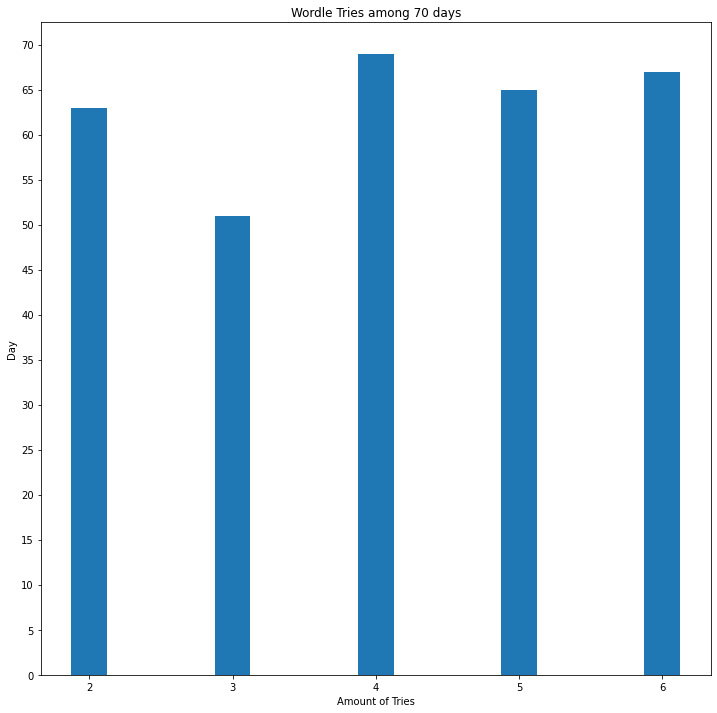

In [607]:
utils.plot_standard_data(cleaned_df.loc[:,"Tries"], cleaned_df.index, "Amount of Tries", "Day", "Wordle Tries among 70 days")

**Analysis:** From this graph we can notice that the highest score that I had gotten on wordle was 4 tries while the lowest score is 3 tries.

This next graph shows a scatterplot between the average weather in Spokane and the wordle tries

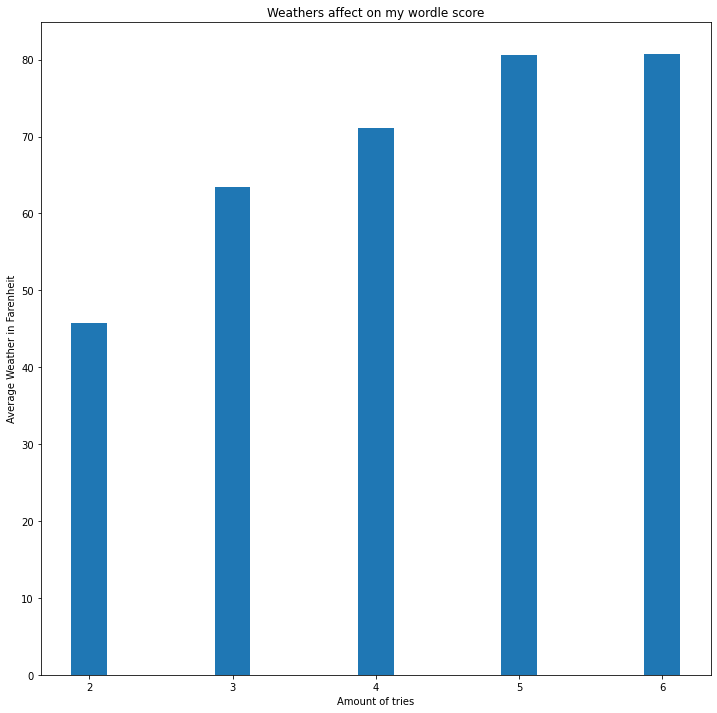

In [608]:
y = weather_wordle_df["tavg"]
x = weather_wordle_df["Tries"]

utils.plot_weather_data(x,y, "Amount of tries", "Average Weather in Farenheit", "Weathers affect on my wordle score")

**Analysis:** In this bar chart it depicts the relation between the daily weather and my wordle score. From the graph there is a correlation with hotter weather and a worse wordle score. 2 tries or even 3 tries is under mid 60s. A possible causation from this could be on hotter days, I usually am more tired from the heat so perhaps playing wordle was harder then it normally should be.